In [1]:
%config IPCompleter.use_jedi = False
import pandas as pd
import warnings 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pathlib import Path

In [2]:
proj_path = str(Path().resolve().parent)

In [3]:
FONT_NAME = 'Arial'
FONT_SIZE = 14 
import matplotlib as mpl
mpl.rc('font',family='Arial')

In [74]:
file_2d = proj_path + "/results/density2D_64_128.csv" 
file_ts = proj_path + "/results/densityTS_64_128.csv"
file_large005 = proj_path + "/results/large2D_64_128.csv"
file_largeTS = proj_path + "/results/largeTS_64_128.csv"
file_batchTS = proj_path + "/results/batchTS_64_128.csv"
file_scalabilityTS = proj_path + "/results/scalabilityTS_64_128.csv"

In [33]:
df_2d_column_names = ['FF', 'FFD-Avg', 'FFD-Max',
       'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Avg', 'BFD-Max',
       'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum', 'BCD-L2Norm', 'BCD-DotProduct',
       'FFD-Degree', 'NodeCount', 'BCD-Fitness']
#df_2d_column_names_reduced = ['FF', 'FFD-Avg', 'BFD-Avg', 'BCD-DotProduct',
#                              'FFD-Degree', 'NodeCount', 'BCD-Fitness'] # Select only some algos

df_2d_large_column_names = ['FF', 'FFD-Avg', 'FFD-Max',
       'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Avg', 'BFD-Max',
       'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum', 'BCD-DotProduct',
       'FFD-Degree', 'BCD-Fitness']


df_ts_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'FFD-Degree']
       #'FFD-Max', 'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Max',
       #'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum']
#df_2d_large_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'FFD-Degree']
       #'FFD-Max', 'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Max',
       #'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum']

df_scalab_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'FFD-Degree']

df_batch_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'BCD-DotProduct',
                         'FFD-Degree', 'BCD-Fitness']

classes = ['arbitrary', 'normal', 'threshold']

rename_dict = {
    "BCD-L2Norm": "NCD-L2Norm",
    "BCD-DotProduct": "NCD-DotProduct",
    "FFD-Degree": "Medea-TP",
    "NodeCount": "Medea-NC",
    "BCD-Fitness": "LRASched-Fitness"
}

In [34]:
## sub_df = any one in df_2d, df_ts, df_large
def get_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[0])
    #sub_df['density'] = sub_df['instance_name'].apply(lambda x: x.split('_')[1])
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['density'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[1][1:]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'density'], as_index=False).mean()
    eps_df = sub_df_grouped_avg[['class', 'density'] + epsilon_column_names]
    time_df = sub_df_grouped_avg[['class', 'density'] + time_column_names]
    return eps_df, time_df

In [35]:
## sub_df = any one in df_2d, df_ts, df_large
def get_scale_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[3])
    sub_df['LRAnum'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[-1]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'LRAnum'], as_index=False).mean()
    sub_df_grouped_avg_eps = sub_df_grouped_avg[['class', 'LRAnum'] + epsilon_column_names]
    sub_df_grouped_avg_time = sub_df_grouped_avg[['class', 'LRAnum'] + time_column_names]
    return sub_df_grouped_avg_eps, sub_df_grouped_avg_time

In [78]:
def plot_density_barchart(original_df, class_name, cols, ylabel):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    #x = np.arange(3)
    width = 0.1
    labels = original_df.density.apply(lambda x: f'{x:,}').unique()
    x = np.arange(len(labels))

    fig = plt.figure(figsize=(15, 5))
    algs = list(tmp_df.T.index)
    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values

    width_class = width * alg_num + 0.5
    #width = 0.95/float(alg_num) # 0.06
    
    curr = alg_num/2.0 + 0.5 #int(alg_num/2)+1
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*', '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

    for i in range(alg_num):
        curr = curr - 1
        plt.bar(x*width_class - width*curr, alg_res[i], width, hatch = hatches[i], alpha=.99)
        #plt.xticks(x*width_class, ['1', '5', '10'],fontsize=FONT_SIZE,fontweight='bold')
        plt.xticks(x*width_class, labels, fontsize=FONT_SIZE,fontweight='bold')
    plt.yticks(fontsize=FONT_SIZE, fontweight='bold')
    plt.xlabel("Affinity density", fontname=FONT_NAME, fontsize=FONT_SIZE, fontweight='bold')
    plt.ylabel(ylabel, fontname=FONT_NAME, fontsize=FONT_SIZE, fontweight='bold')
    #plt.title(class_name, fontsize=FONT_SIZE, fontweight='bold')
    plt.legend(algs, loc='upper left', bbox_to_anchor=(0, -0.16), ncol=6, fancybox=True, shadow=False, fontsize=FONT_SIZE-1)
    plt.tight_layout()
    plt.show()
    return fig

In [131]:
def plot_density_barchart_logscale(original_df, class_name, cols, ylabel):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    #x = np.arange(3)
    width = 0.1
    labels = original_df.density.apply(lambda x: f'{x:,}').unique()
    x = np.arange(len(labels))

    fig = plt.figure(figsize=(15, 5))
    algs = list(tmp_df.T.index)
    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values

    width_class = width * alg_num + 0.5
    #width = 0.95/float(alg_num) # 0.06
    
    curr = alg_num/2.0 + 0.5 #int(alg_num/2)+1
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*', '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

    for i in range(alg_num):
        curr = curr - 1
        plt.bar(x*width_class - width*curr, alg_res[i], width, hatch = hatches[i], alpha=.99)
        #plt.xticks(x*width_class, ['1', '5', '10'],fontsize=FONT_SIZE,fontweight='bold')
        plt.xticks(x*width_class, labels, fontsize=FONT_SIZE,fontweight='bold')
    plt.yticks(fontsize=FONT_SIZE, fontweight='bold')
    plt.xlabel("Affinity density", fontname=FONT_NAME, fontsize=FONT_SIZE, fontweight='bold')
    plt.ylabel(ylabel, fontname=FONT_NAME, fontsize=FONT_SIZE, fontweight='bold')
    plt.yscale('log')
    #plt.title(class_name, fontsize=FONT_SIZE, fontweight='bold')
    plt.legend(algs, loc='upper left', bbox_to_anchor=(0, -0.16), ncol=6, fancybox=True, shadow=False, fontsize=FONT_SIZE-1)
    plt.tight_layout()
    plt.show()
    return fig

In [81]:
def plot_scale_barchart(original_df, class_name, cols, ylabel):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    #x = np.arange(3)
    width = 0.1
    labels = original_df.LRAnum.apply(lambda x: f'{x:,}').unique()
    x = np.arange(len(labels))

    fig = plt.figure(figsize=(15, 5))
    algs = list(tmp_df.T.index)
    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values

    width_class = width * alg_num + 0.5
    
    curr = alg_num/2.0 + 0.5 #int(alg_num/2)+1
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*', '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

    for i in range(alg_num):
        curr = curr - 1
        plt.bar(x*width_class - width*curr, alg_res[i], width, hatch = hatches[i], alpha=.99)
        plt.xticks(x*width_class, labels, fontsize=FONT_SIZE, fontweight='bold')
    plt.xlabel("Number of submitted LRAs", fontname=FONT_NAME, fontsize=FONT_SIZE, fontweight='bold')
    plt.ylabel(ylabel, fontname=FONT_NAME, fontsize=FONT_SIZE, fontweight='bold')
    plt.yticks(fontsize=FONT_SIZE, fontweight='bold')
    #plt.title(class_name, fontsize=FONT_SIZE, fontweight='bold')
    plt.legend(algs, loc='upper left', bbox_to_anchor=(0, -0.16), ncol=6, fancybox=True, shadow=False, fontsize=FONT_SIZE-1) 
    plt.tight_layout()
    plt.show()
    return fig

In [82]:
def plot_scale_barchart_logscale(original_df, class_name, cols, ylabel):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    #x = np.arange(3)
    labels = original_df.LRAnum.apply(lambda x: f'{x:,}').unique()
    x = np.arange(len(labels))

    fig = plt.figure(figsize=(15, 5))
    algs = list(tmp_df.T.index)
    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values
    
    width = 0.95/float(alg_num) # 0.06

    curr = alg_num/2.0 + 0.5 #int(alg_num/2)+1
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*', '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

    for i in range(alg_num):
        curr = curr - 1
        plt.bar(x-width*curr, alg_res[i], width, hatch = hatches[i], alpha=.99)
        plt.xticks(x, labels, fontsize=FONT_SIZE, fontweight='bold')
    plt.xlabel("Number of submitted LRAs", fontname=FONT_NAME, fontsize=FONT_SIZE, fontweight='bold')
    plt.ylabel(ylabel, fontname=FONT_NAME, fontsize=FONT_SIZE, fontweight='bold')
    plt.yscale('log')
    plt.yticks(fontsize=FONT_SIZE, fontweight='bold')
    #plt.title(class_name, fontsize=FONT_SIZE, fontweight='bold')
    plt.legend(algs, loc='upper left', bbox_to_anchor=(0, -0.16), ncol=6, fancybox=True, shadow=False, fontsize=FONT_SIZE-1) 
    plt.tight_layout()
    plt.show()
    return fig

# Result-1: 2D Fixed Res Request

## 1.1 Impact of Affinity Density On Effectiveness and Time Consumption

In [125]:
df_2d = pd.read_csv(file_2d, sep='\t')
twodim_eps, twodim_time = get_exp_results(df_2d, df_2d_column_names)
twodim_eps.columns = ['class', 'density'] + df_2d_column_names
twodim_time.columns = ['class', 'density'] + df_2d_column_names

#### The algorithm effectivenss and time consumption of the three different classes 

In [ ]:
twodim_eps[twodim_eps['class'] == 'arbitrary'].sort_values(by='density')

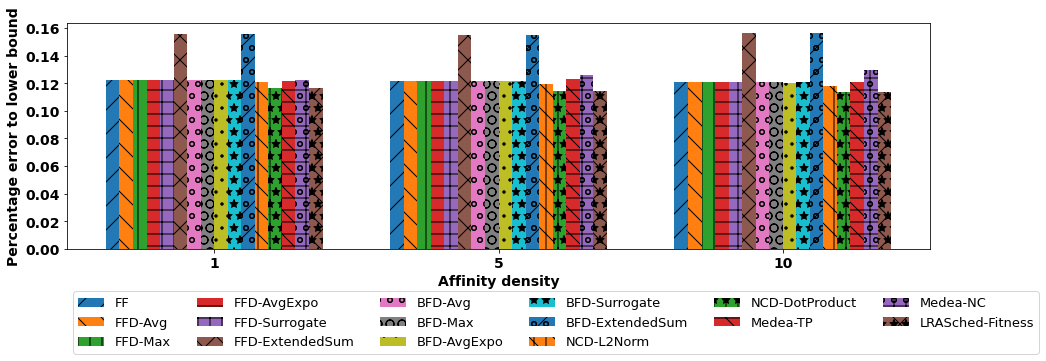

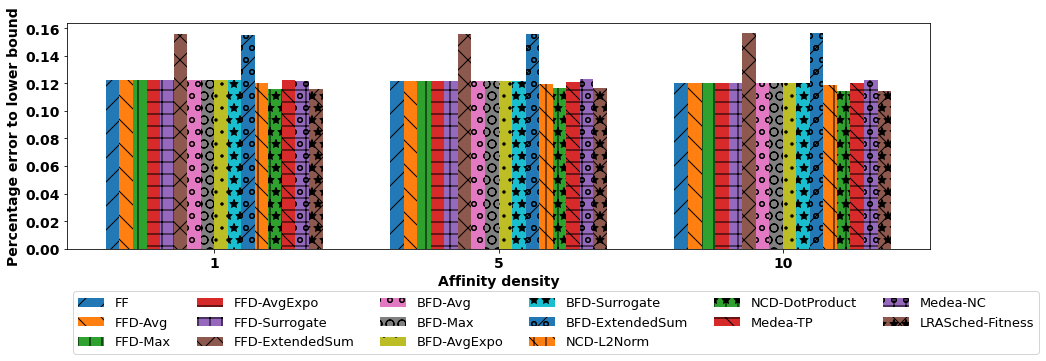

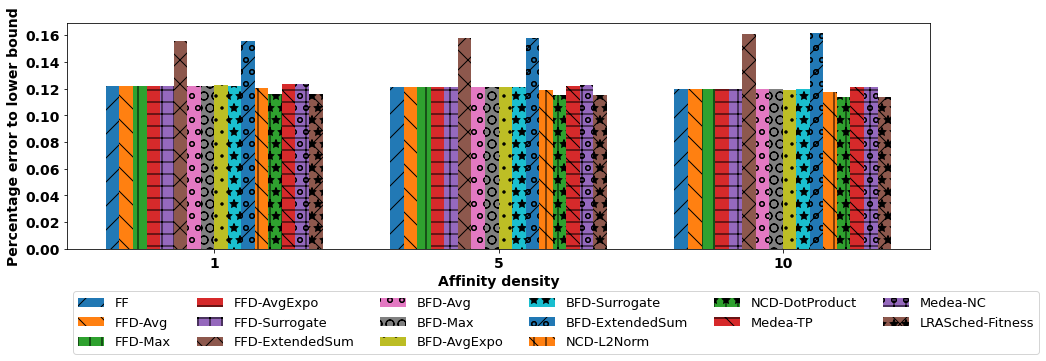

In [127]:
for c in classes: 
    fig = plot_density_barchart(twodim_eps, c, df_2d_column_names, 'Percentage error to lower bound')
    filename = f"{proj_path}/plots/density2D_result_{c}.pdf" 
    fig.savefig(filename)

In [ ]:
#for c in classes: 
#    plot_density_barchart(twodim_time, c, df_2d_column_names, 'Time consumption (s)')

If removing the time consumption of NodeCount:

In [41]:
time_cols_without_nodecount = df_2d_column_names.copy()
time_cols_without_nodecount.remove("NodeCount")

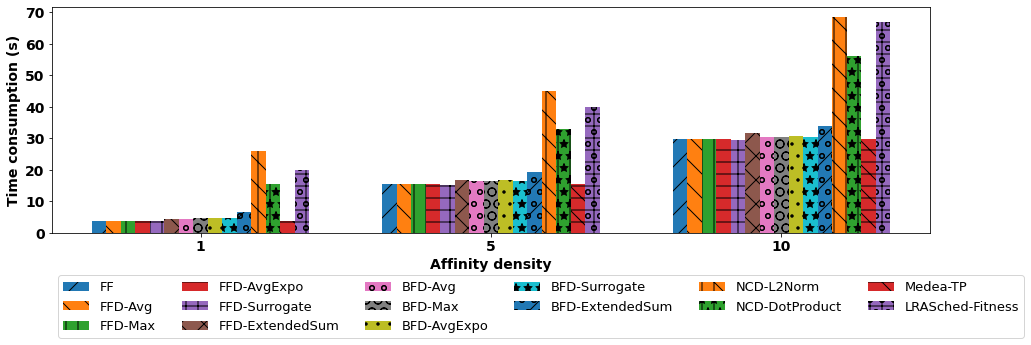

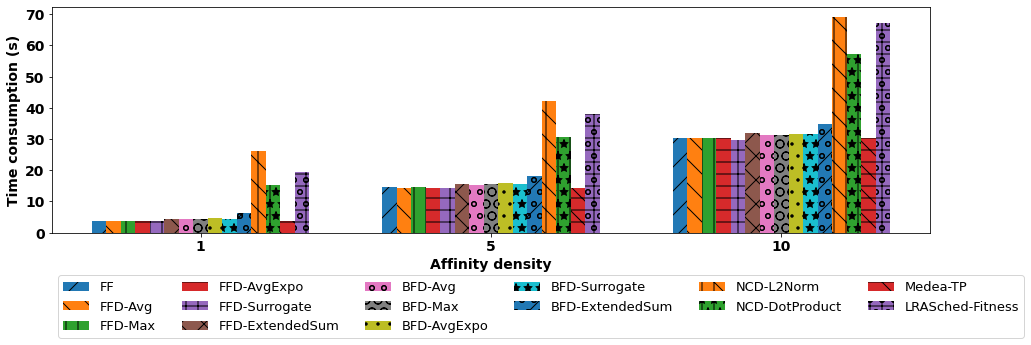

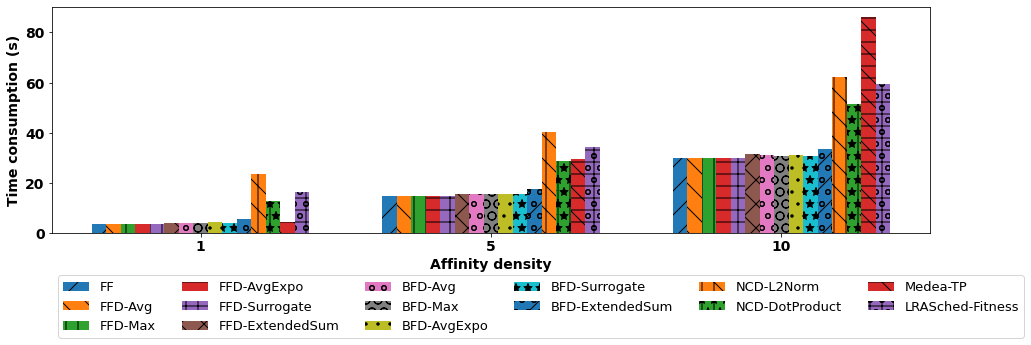

In [42]:
for c in classes: 
    fig = plot_density_barchart(twodim_time, c, time_cols_without_nodecount, 'Time consumption (s)')
    
    filename = f"{proj_path}/plots/density2D_time_{c}.pdf" 
    fig.savefig(filename)

## 1.2 Impact of LRA Submission Scale on Effectiveness and Time Consumption 

In [84]:
df_large005 = pd.read_csv(file_large005, sep='\t') ## df_2d_large

twodim_eps_scale, twodim_time_scale = get_scale_exp_results(df_large005, df_2d_large_column_names)
twodim_eps_scale.columns = ['class', 'LRAnum'] + df_2d_large_column_names
twodim_time_scale.columns = ['class', 'LRAnum'] + df_2d_large_column_names

In [28]:
twodim_eps_scale

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-DotProduct,FFD-Degree
0,arbitrary,10000,0.0267,0.0267,0.0267,0.0267,0.0267,0.0338,0.0267,0.0267,0.0272,0.0267,0.0338,0.0263,0.0269
1,arbitrary,50000,0.0245,0.0245,0.0245,0.0245,0.0245,0.0381,0.0245,0.0245,0.0245,0.0245,0.0380,0.0235,0.0244
2,arbitrary,100000,0.0240,0.0240,0.0240,0.0240,0.0240,0.0379,0.0240,0.0240,0.0239,0.0240,0.0378,0.0232,0.0241
3,normal,10000,0.0271,0.0271,0.0271,0.0271,0.0271,0.0337,0.0271,0.0271,0.0272,0.0271,0.0337,0.0260,0.0265
4,normal,50000,0.0245,0.0245,0.0245,0.0245,0.0245,0.0381,0.0245,0.0245,0.0245,0.0245,0.0379,0.0235,0.0241
5,normal,100000,0.0240,0.0240,0.0240,0.0240,0.0240,0.0377,0.0240,0.0240,0.0239,0.0240,0.0378,0.0232,0.0239
6,threshold,10000,0.0271,0.0271,0.0271,0.0271,0.0271,0.0340,0.0271,0.0271,0.0273,0.0271,0.0340,0.0258,0.0267
7,threshold,50000,0.0244,0.0244,0.0244,0.0244,0.0244,0.0384,0.0244,0.0244,0.0245,0.0244,0.0383,0.0232,0.0240
8,threshold,100000,0.0238,0.0238,0.0238,0.0238,0.0238,0.0378,0.0238,0.0238,0.0240,0.0238,0.0378,0.0231,0.0233


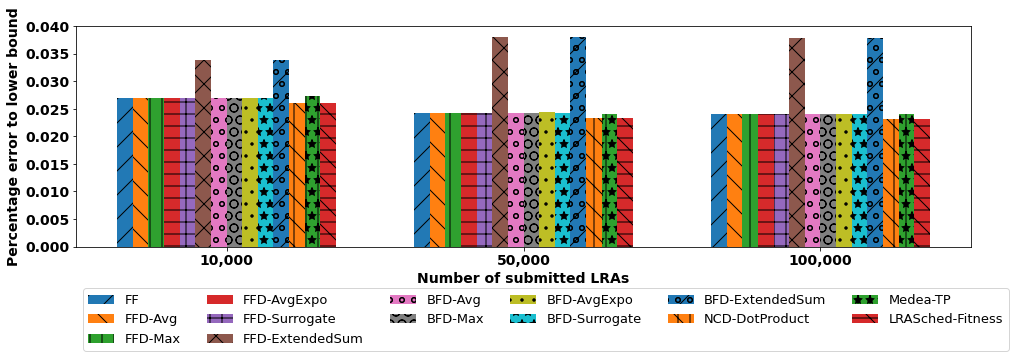

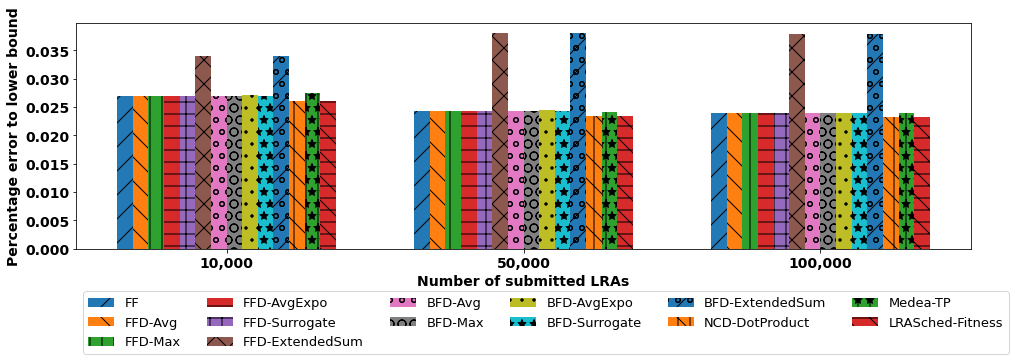

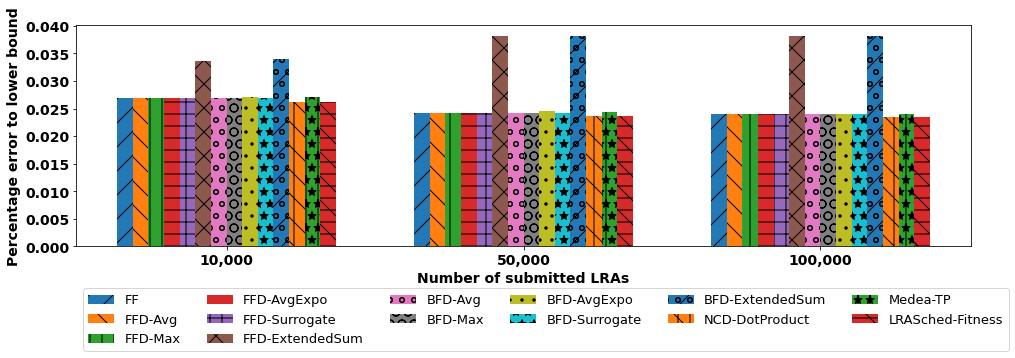

In [85]:
for c in classes:
    fig = plot_scale_barchart(twodim_eps_scale, c, df_2d_large_column_names, 'Percentage error to lower bound')    
    filename = f"{proj_path}/plots/large2D_result_{c}.pdf" 
    fig.savefig(filename)

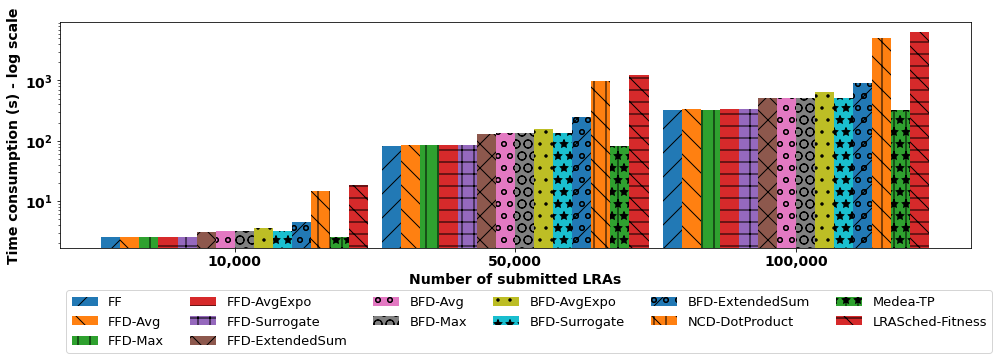

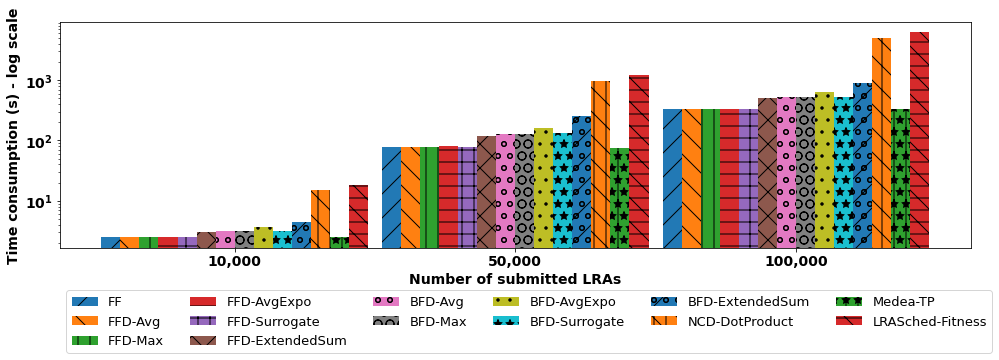

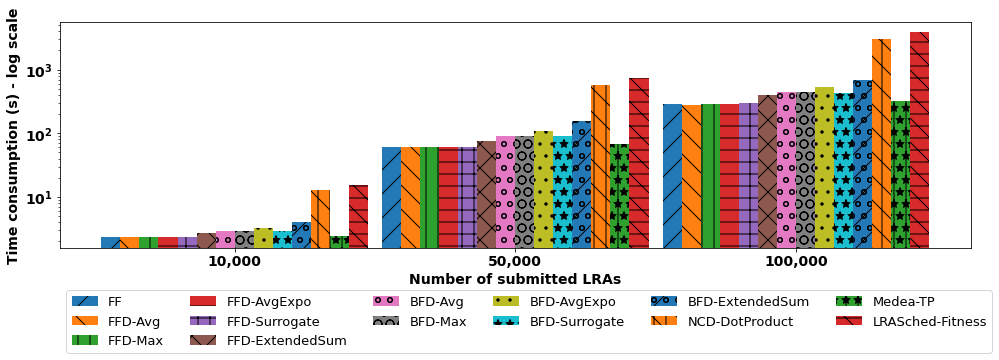

In [86]:
for c in classes:
    #fig = plot_scale_barchart(twodim_time_scale, c, df_2d_large_column_names, 'Time consumption (s)')
    fig = plot_scale_barchart_logscale(twodim_time_scale, c, df_2d_large_column_names, 'Time consumption (s) - log scale')
    
    filename = f"{proj_path}/plots/large2D_time_{c}.pdf" 
    fig.savefig(filename)

# Result-2: Time-Varying Res Request

In [46]:
df_ts = pd.read_csv(file_ts, sep='\t')
ts_eps, ts_time = get_exp_results(df_ts, df_ts_column_names)
ts_eps.columns = ['class', 'density'] + df_ts_column_names
ts_time.columns = ['class', 'density'] + df_ts_column_names

## 2.1 Impact of Affinity Density On Effectiveness and Time Consumption

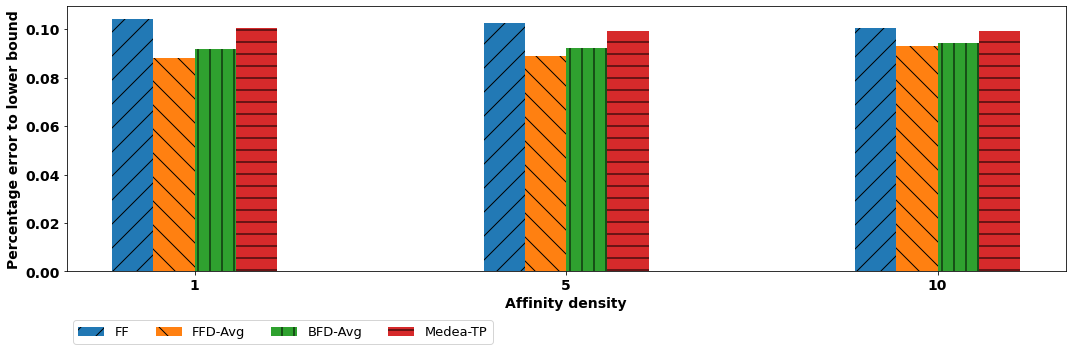

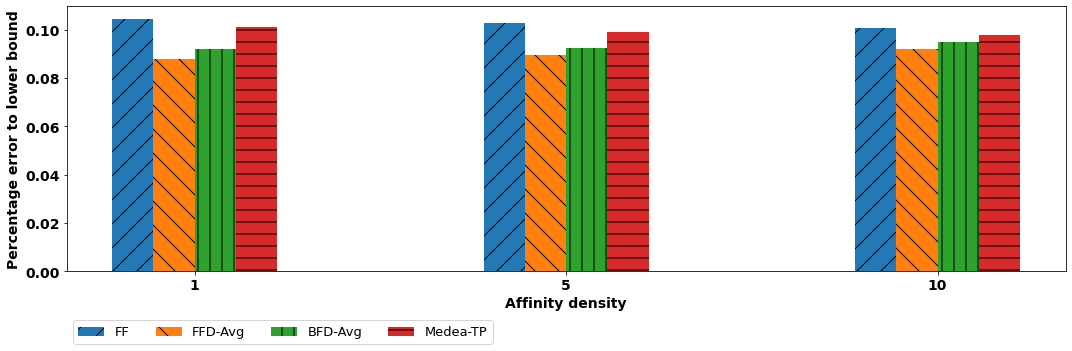

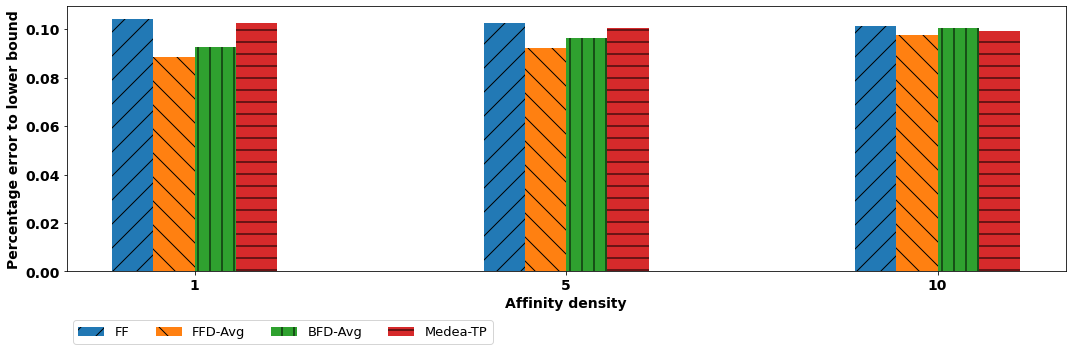

In [50]:
for c in classes: 
    fig = plot_density_barchart(ts_eps, c, df_ts_column_names, 'Percentage error to lower bound')
    
    filename = f"{proj_path}/plots/densityTS_result_{c}.pdf" 
    fig.savefig(filename)

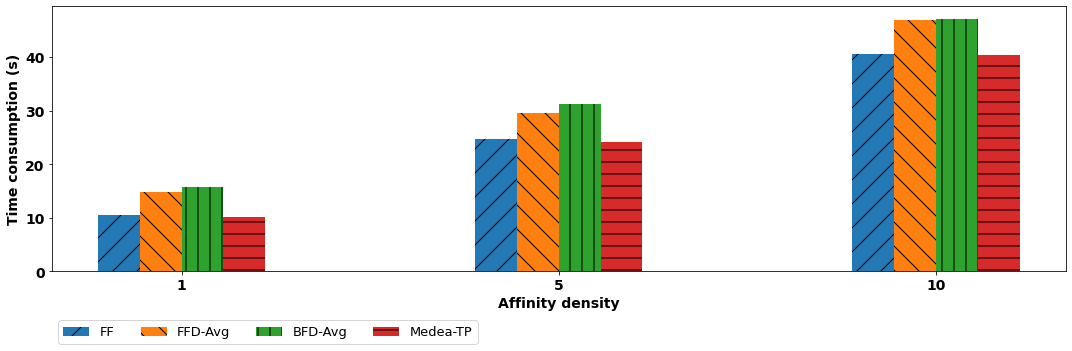

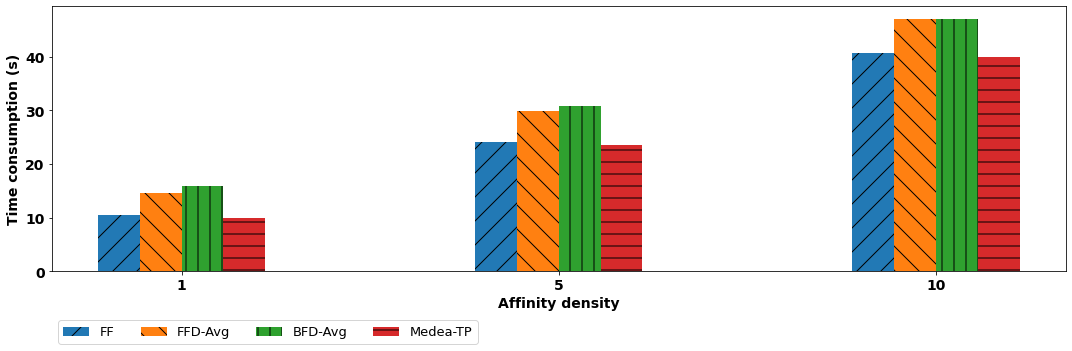

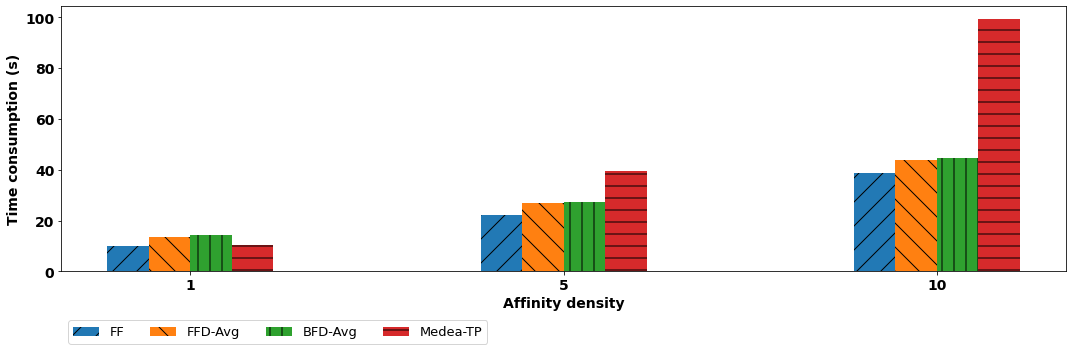

In [51]:
for c in classes: 
    fig = plot_density_barchart(ts_time, c, df_ts_column_names, 'Time consumption (s)')
    
    filename = f"{proj_path}/plots/densityTS_time_{c}.pdf" 
    fig.savefig(filename)

## 2.2 Impact of LRA Submission Scale On Effectiveness and Time Consumption

In [97]:
df_large_ts = pd.read_csv(file_largeTS, sep='\t') ## df_TS_large

ts_eps_scale, ts_time_scale = get_scale_exp_results(df_large_ts, df_ts_column_names)
ts_eps_scale.columns = ['class', 'LRAnum'] + df_ts_column_names
ts_time_scale.columns = ['class', 'LRAnum'] + df_ts_column_names

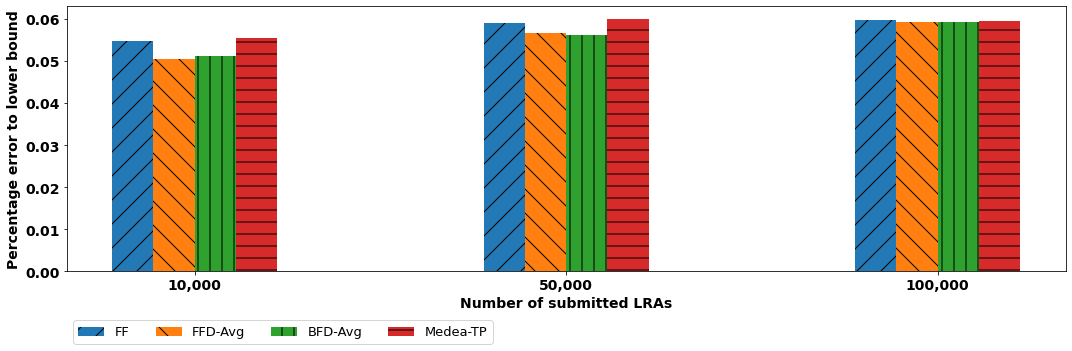

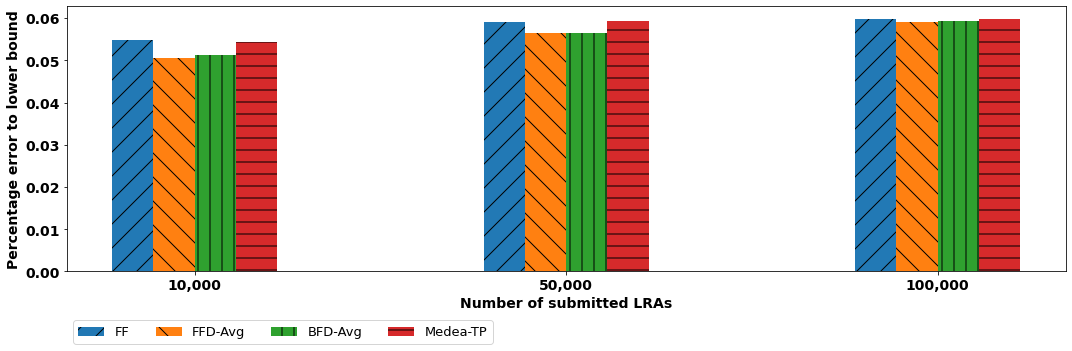

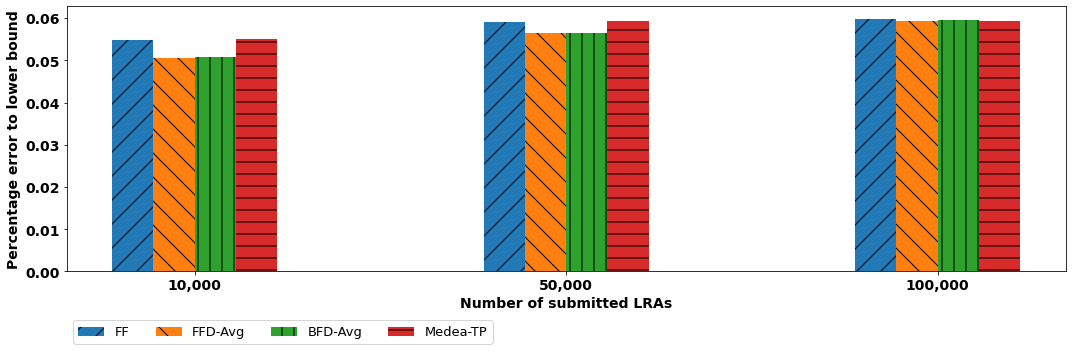

In [98]:
for c in classes:
    fig = plot_scale_barchart(ts_eps_scale, c, df_ts_column_names, 'Percentage error to lower bound')    
    filename = f"{proj_path}/plots/largeTS_result_{c}.pdf" 
    fig.savefig(filename)

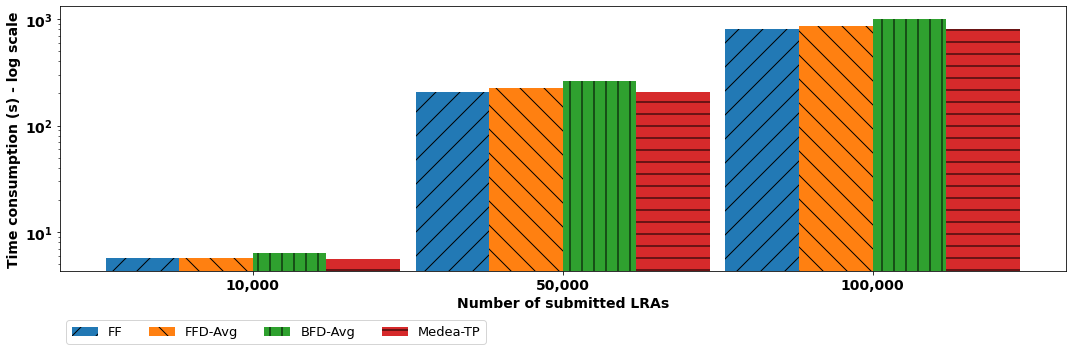

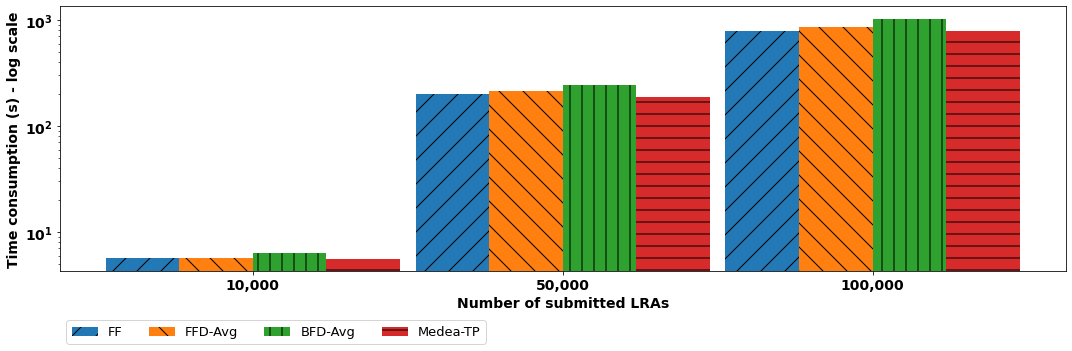

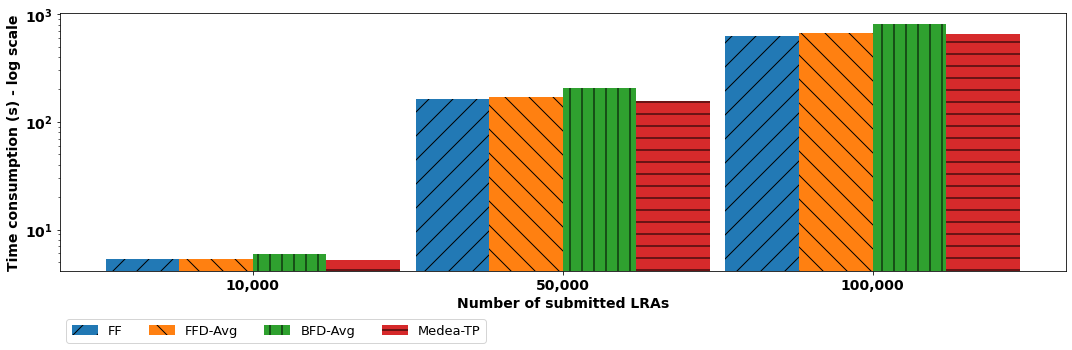

In [99]:
for c in classes:
    fig = plot_scale_barchart_logscale(ts_time_scale, c, df_ts_column_names, 'Time consumption (s) - log scale')
    
    filename = f"{proj_path}/plots/largeTS_time_{c}.pdf" 
    fig.savefig(filename)

# Result-3: Scalability with Varying Res Request

In [100]:
def get_scalability_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[2])
    sub_df['LRAnum'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[1]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    #sub_df_grouped_avg = sub_df.groupby(by = ['class', 'LRAnum'], as_index=False).mean()
    #sub_df_grouped_avg_eps = sub_df_grouped_avg[['class', 'LRAnum'] + epsilon_column_names]
    #sub_df_grouped_avg_time = sub_df_grouped_avg[['class', 'LRAnum'] + time_column_names]
    #return sub_df_grouped_avg_eps, sub_df_grouped_avg_time
    df_eps = sub_df[['class', 'LRAnum'] + epsilon_column_names]
    df_time = sub_df[['class', 'LRAnum'] + time_column_names]
    return df_eps, df_time

In [101]:
df_scalab = pd.read_csv(file_scalabilityTS, sep='\t')
scalab_eps, scalab_time = get_scalability_exp_results(df_scalab, df_scalab_column_names)
scalab_eps.columns = ['class', 'LRAnum'] + df_scalab_column_names
scalab_time.columns = ['class', 'LRAnum'] + df_scalab_column_names

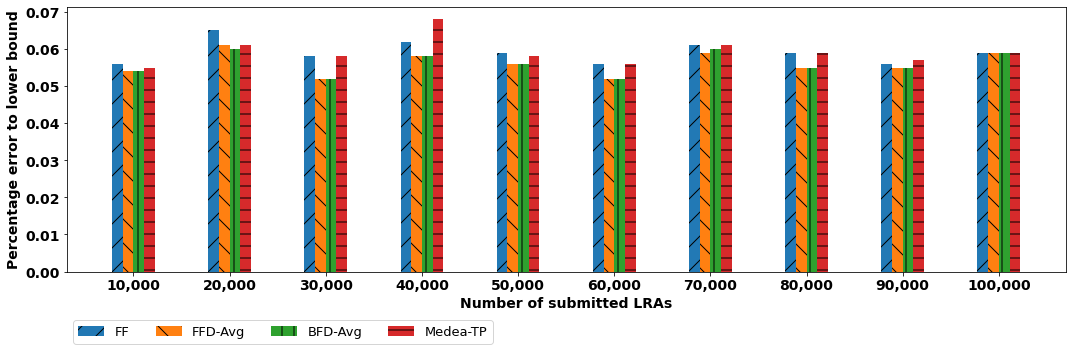

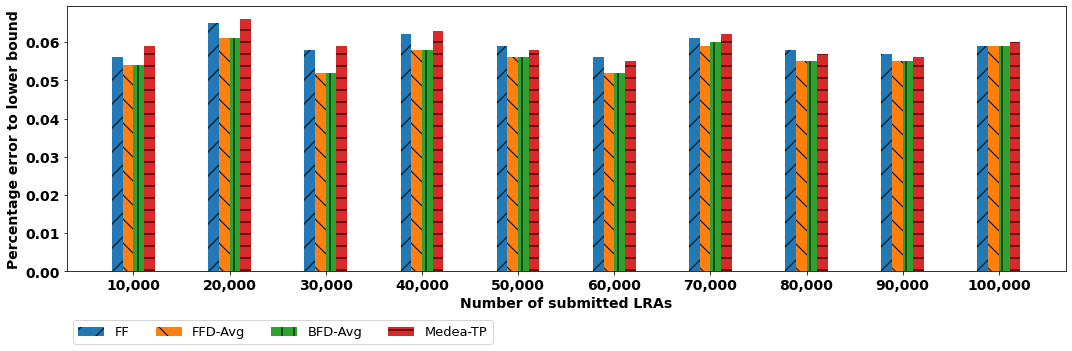

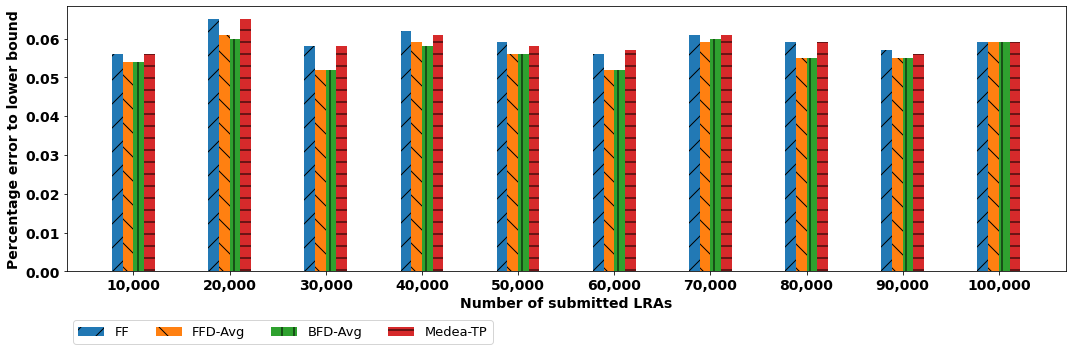

In [102]:
for c in classes:
    fig = plot_scale_barchart(scalab_eps, c, df_scalab_column_names, 'Percentage error to lower bound')    
    filename = f"{proj_path}/plots/scalabilityTS_result_{c}.pdf" 
    #fig.savefig(filename)

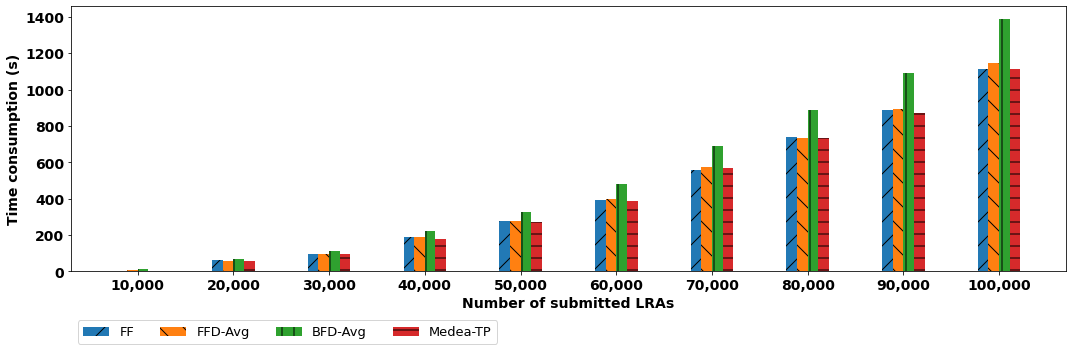

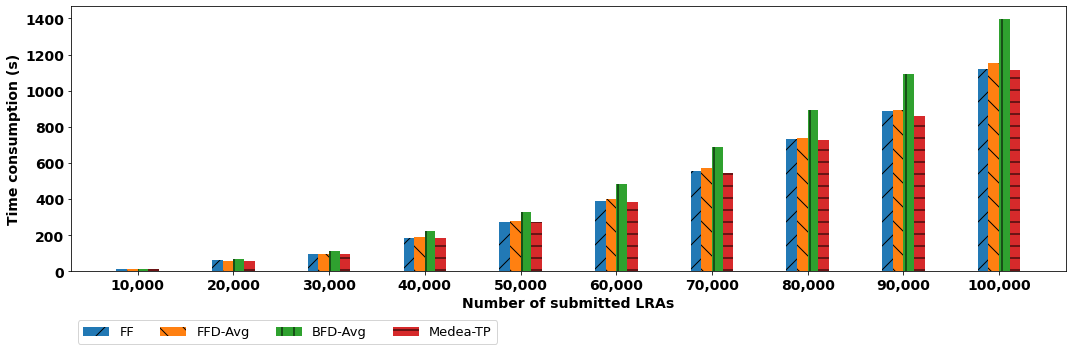

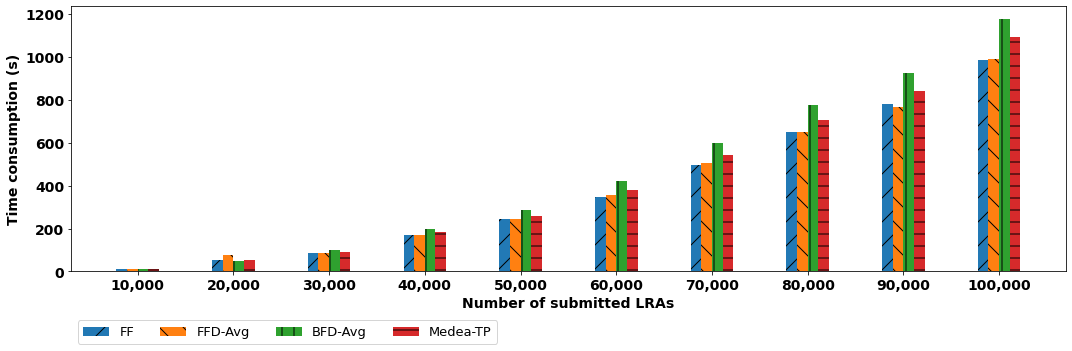

In [103]:
for c in classes:
    #fig = plot_scale_barchart_logscale(scalab_time, c, df_ts_column_names, 'Time consumption (s) - log scale')
    fig = plot_scale_barchart(scalab_time, c, df_ts_column_names, 'Time consumption (s)')
    
    filename = f"{proj_path}/plots/scalabilityTS_time_{c}.pdf" 
    fig.savefig(filename)

# Result-4: Scheduling per Batch with Varying Res Request

In [122]:
df_batch = pd.read_csv(file_batchTS, sep='\t')
batch_eps, batch_time = get_exp_results(df_batch, df_batch_column_names)
batch_eps.columns = ['class', 'density'] + df_batch_column_names
batch_time.columns = ['class', 'density'] + df_batch_column_names

In [123]:
df_batch.head()

,instance_name,LB,FF,FFD-Degree,FFD-Avg,BFD-Avg,BCD-DotProduct,BCD-Fitness,FF_time,FFD-Degree_time,...,BCD-Fitness_time,class,idx,density,FF_eps,FFD-Avg_eps,BFD-Avg_eps,BCD-DotProduct_eps,FFD-Degree_eps,BCD-Fitness_eps
0,arbitrary_d1_0,4952,5469,5454,5554,5553,5631,5621,15.423,17.895,...,949.477,arbitrary,0,1,0.104,0.122,0.121,0.137,0.101,0.135
1,arbitrary_d1_1,4952,5470,5469,5549,5554,5638,5628,16.533,16.779,...,963.886,arbitrary,1,1,0.105,0.121,0.122,0.139,0.104,0.137
2,arbitrary_d1_2,4952,5468,5466,5545,5552,5628,5621,16.273,9.175,...,939.306,arbitrary,2,1,0.104,0.120,0.121,0.137,0.104,0.135
3,arbitrary_d1_3,4952,5466,5451,5551,5551,5636,5629,15.710,13.650,...,915.678,arbitrary,3,1,0.104,0.121,0.121,0.138,0.101,0.137
4,arbitrary_d1_4,4952,5466,5460,5552,5554,5636,5630,13.707,16.138,...,913.542,arbitrary,4,1,0.104,0.121,0.122,0.138,0.103,0.137


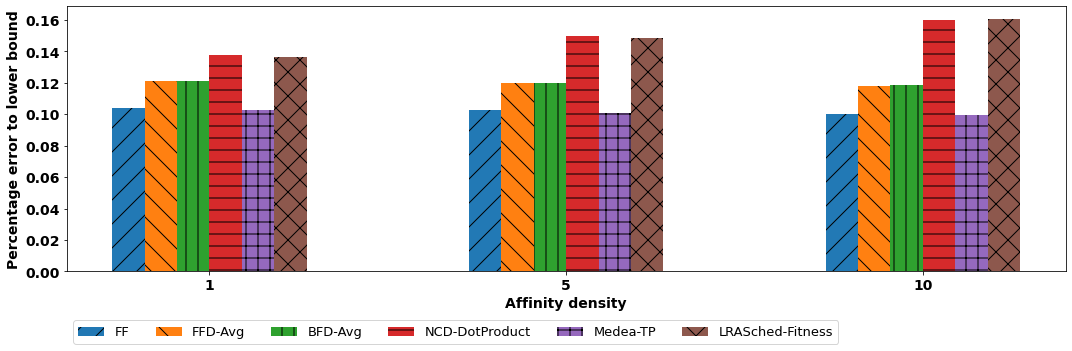

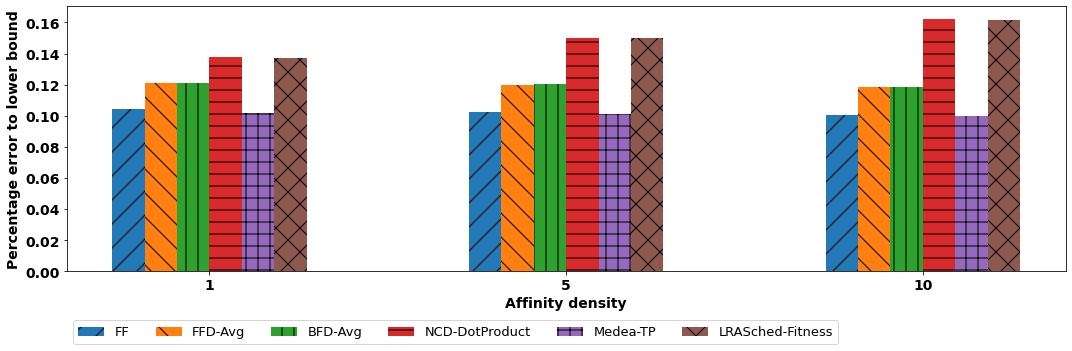

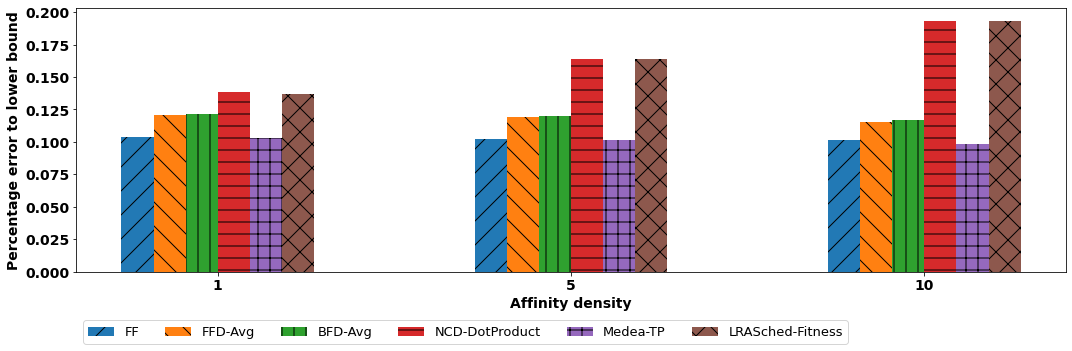

In [128]:
for c in classes: 
    fig = plot_density_barchart(batch_eps, c, df_batch_column_names, 'Percentage error to lower bound')
    
    filename = f"{proj_path}/plots/batchTS_result_{c}.pdf" 
    fig.savefig(filename)

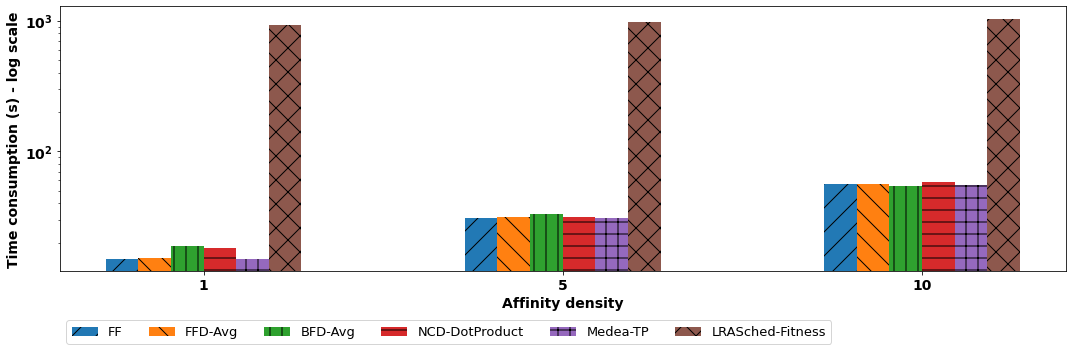

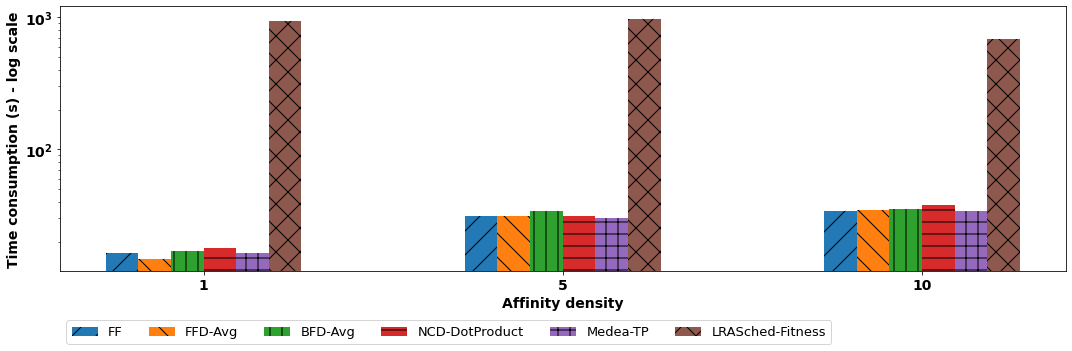

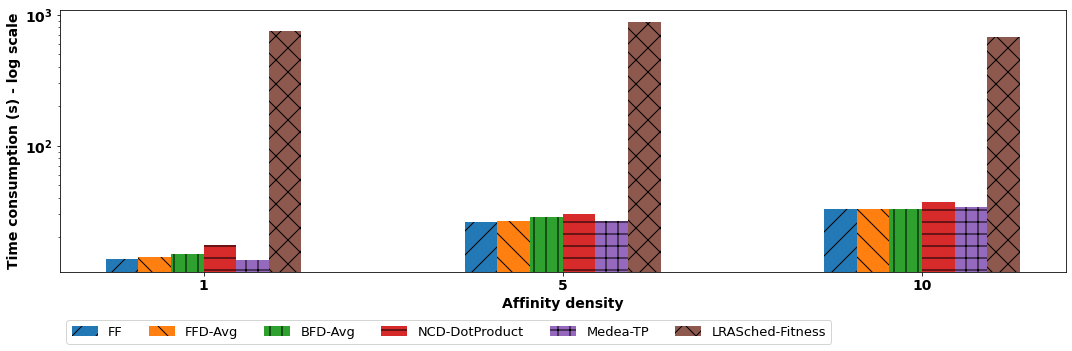

In [132]:
for c in classes: 
    fig = plot_density_barchart_logscale(batch_time, c, df_batch_column_names, 'Time consumption (s) - log scale')
    
    filename = f"{proj_path}/plots/batchTS_time_{c}.pdf" 
    fig.savefig(filename)